# Analyze and predict potential customers based on customer clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from tensorflow.python.keras.metrics import Accuracy

# from autoencoder import SimpleAutoencoder
# import autoencoder
# import tensorflow as tf
# from keras import layers, losses, Model

## 1. Data Cleaning

In [3]:
df = pd.read_csv("data/Customer Segmentation/customer_segmentation.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
df.drop(columns=['ID']).describe()


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [6]:
df = df.dropna()
print("Total missing values are:", len(df))

Total missing values are: 2216


In [7]:
df["Marital_Status"].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

### RFM Analysis

In [8]:
df["Marital_Status"] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Single":"Alone","Divorced":"Alone", "Widow":"Alone", "Absurd":"Alone", "YOLO":"Alone"})

df["Marital_Status"] = df["Marital_Status"].replace({"Partner":2, "Alone":1})
df["Family_Size"] = df["Marital_Status"] + df["Kidhome"] + df["Teenhome"]

# df["Monetary"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
# df["Frequent_Purchase"] = df["NumDealsPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"] + df["NumWebPurchases"]
df = df.drop(columns=["Year_Birth","Education","Dt_Customer","Z_CostContact", "Z_Revenue"],axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\867792939.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Marital_Status"] = df["Marital_Status"].replace({"Partner":2, "Alone":1})


In [9]:
df.describe()

,ID,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,1.645307,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,2.592509
std,3249.376275,0.478528,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,0.905722
min,0.000000,1.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2814.750000,1.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5458.500000,2.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,8421.750000,2.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,11191.000000,2.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


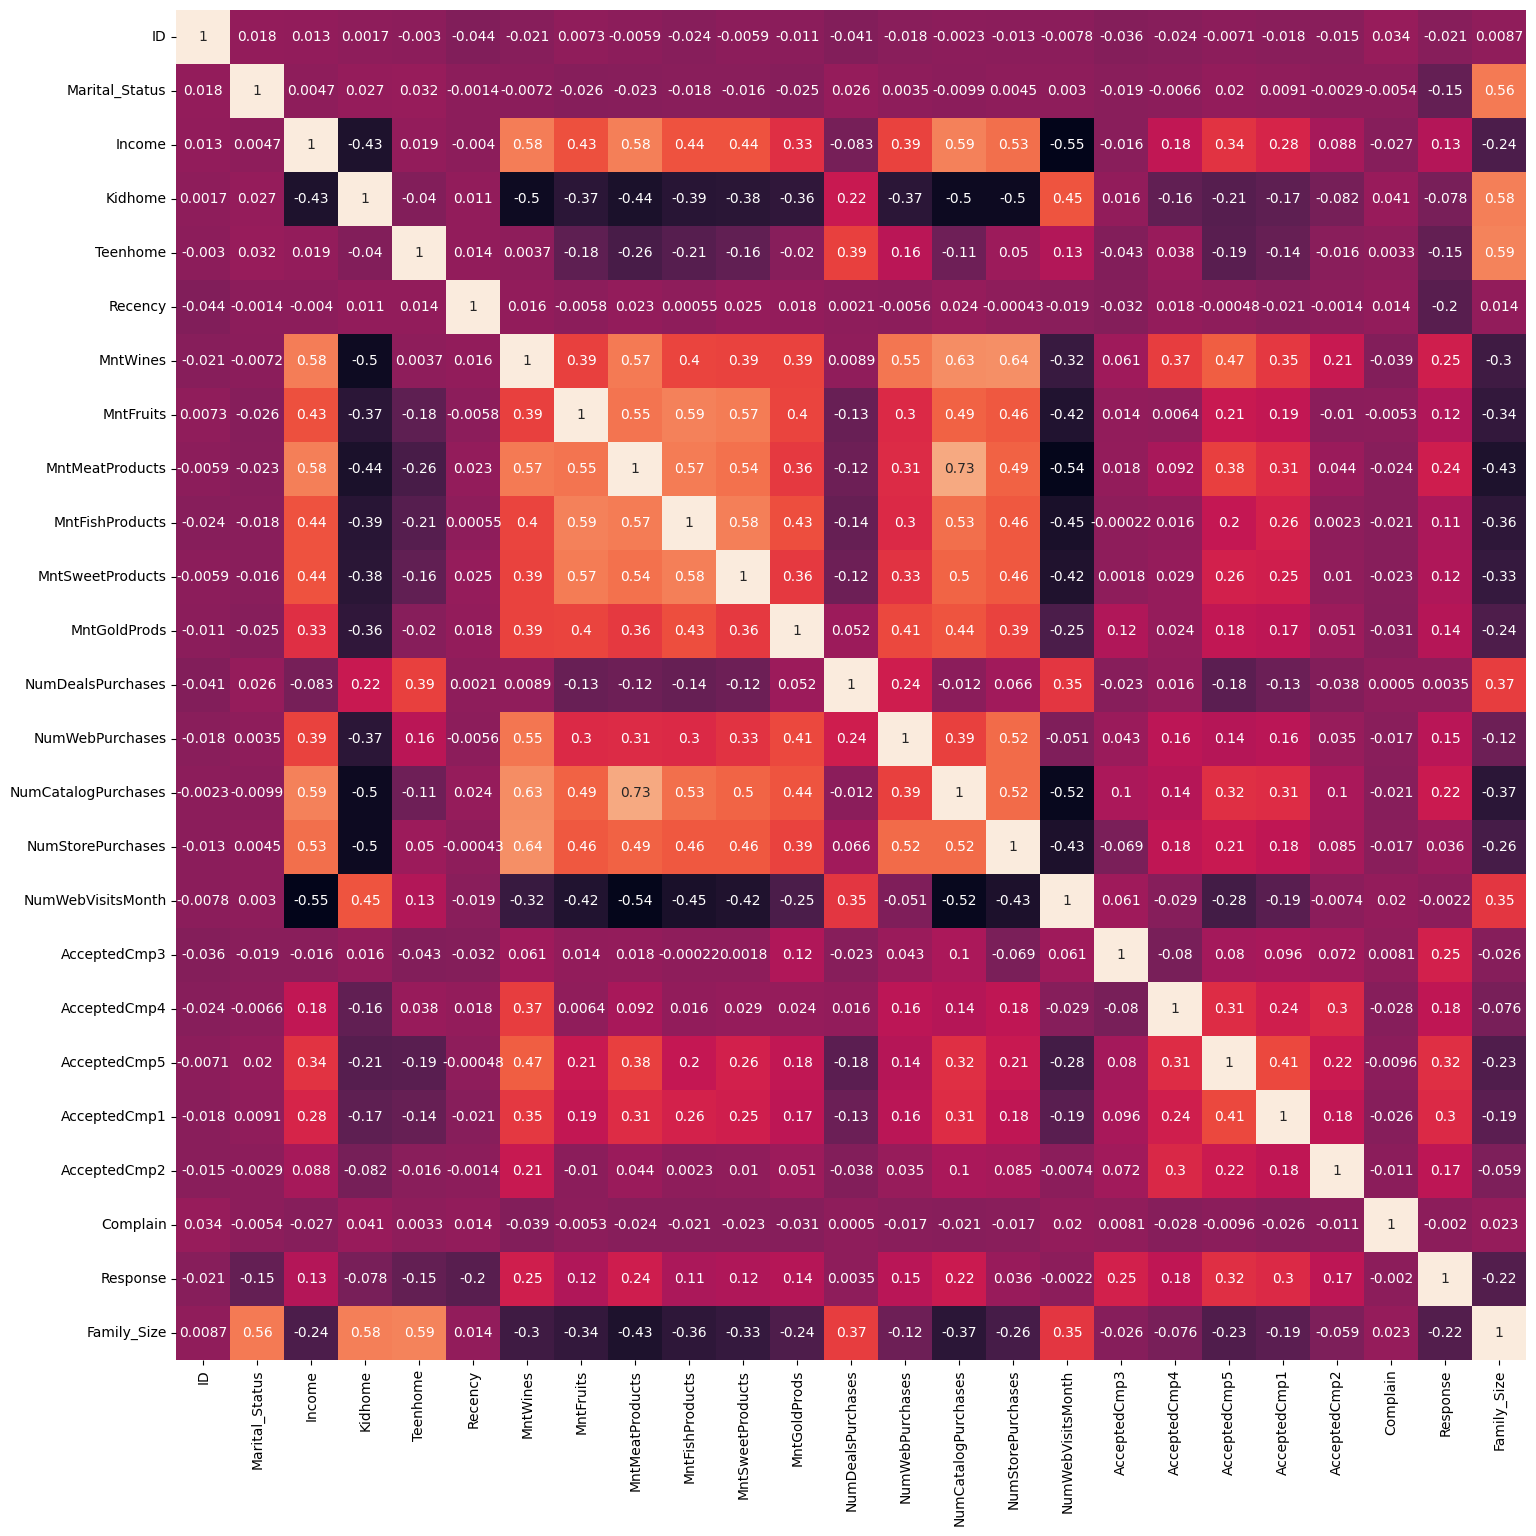

In [10]:
plt.figure(figsize=(15, 15))
sb.heatmap(df.corr(), annot=True, cbar=False)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
plt.show()

## 2. Data Processing

In [11]:
df = df.drop(columns=["Complain","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5",
                      "AcceptedCmp1","AcceptedCmp2","Response"],axis=1)

In [12]:
# plt.figure(figsize=(10, 6))
# sb.scatterplot(x=df['Income'], y=df['Monetary'], alpha=0.6)
# sb.regplot(x=df['Income'], y=df['Monetary'], scatter=False, color='red')
# plt.title('Income vs Total Spent')
# plt.xlabel('Income')
# plt.ylabel('Total Spent')
# plt.grid(alpha=0.3)
# plt.show()

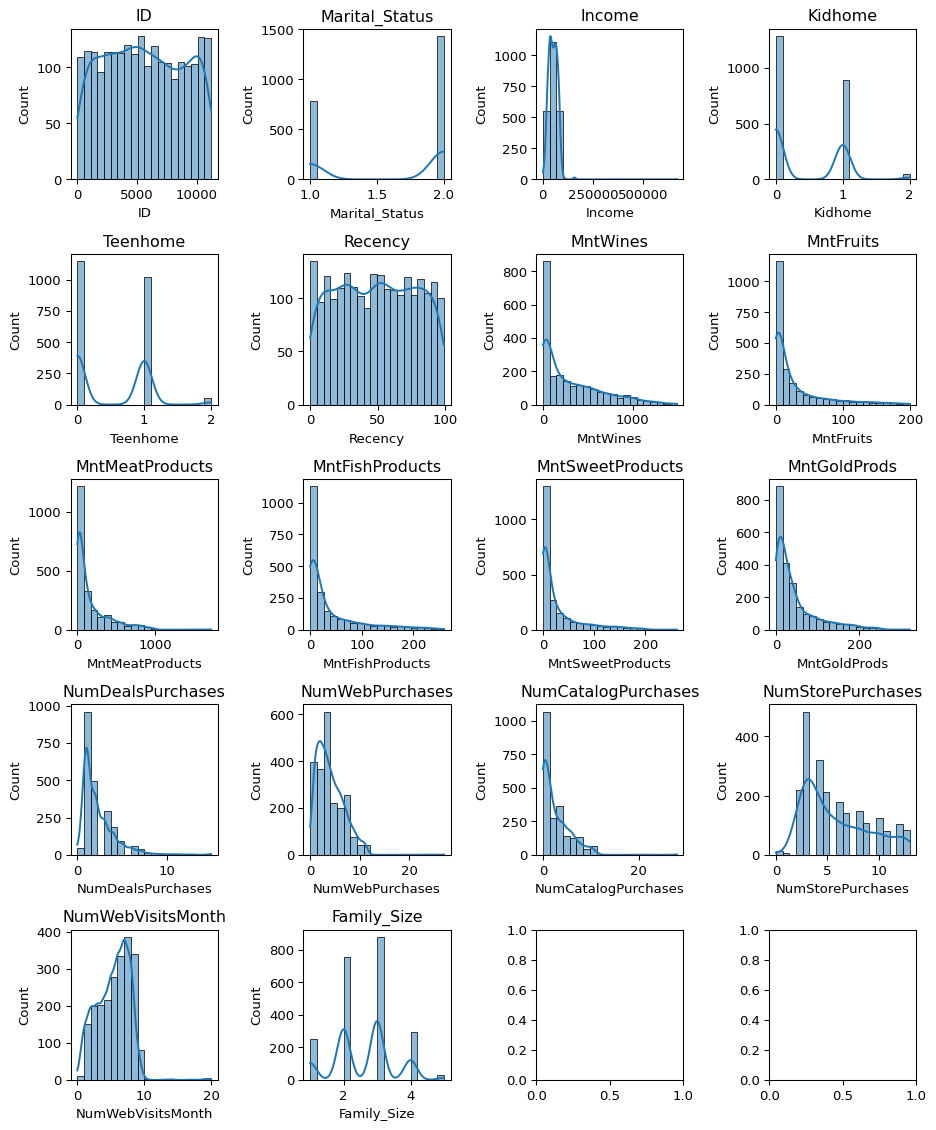

In [13]:
fig, axs = plt.subplots(5,4,dpi=95, figsize=(10,12))
axs = axs.flatten()

for i, col in enumerate(df.columns):
    sb.histplot(df[col], bins=20, kde=True, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()


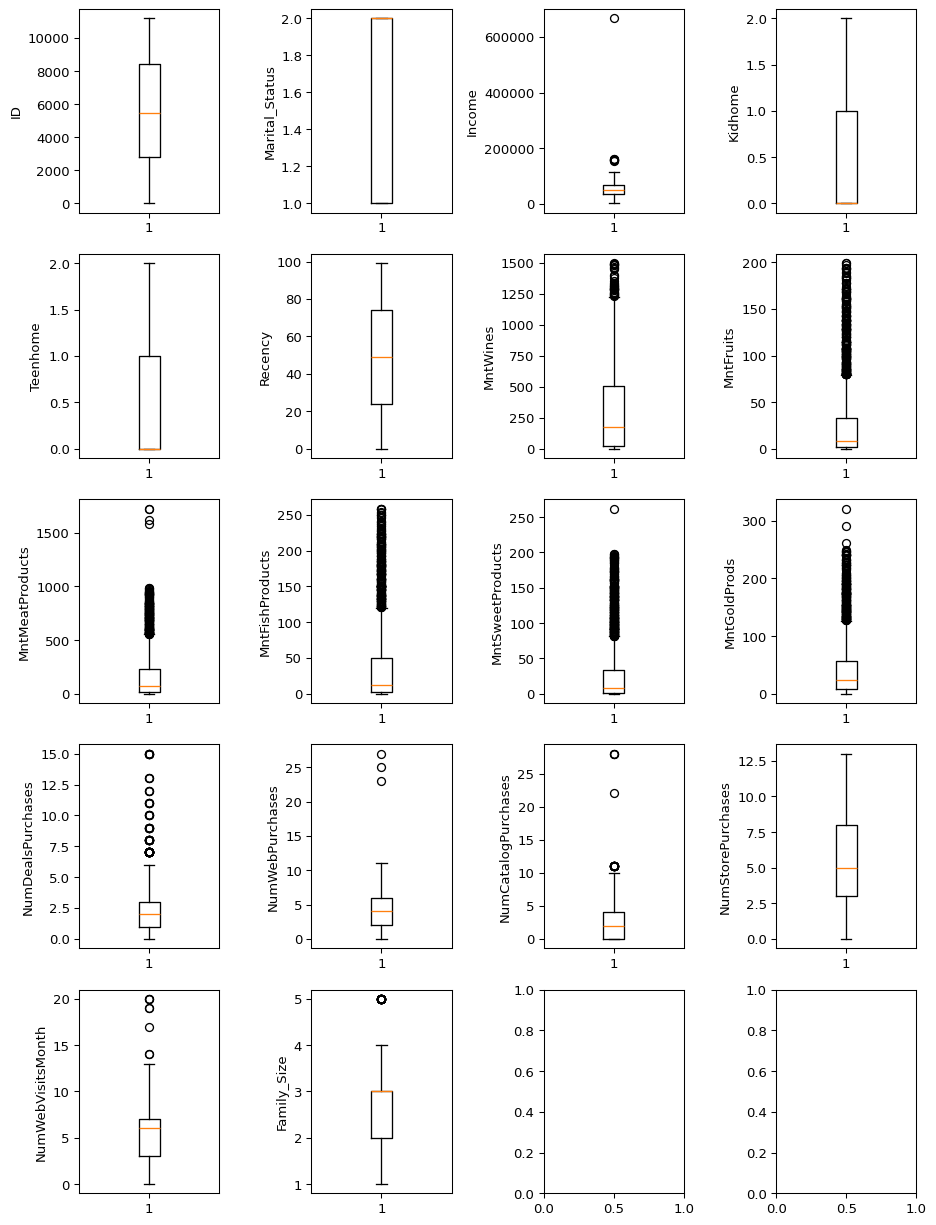

In [14]:
# Box Plots
fig, axs = plt.subplots(5,4,dpi=95, figsize=(10,13))
# i = 0
# for col in df.columns:
#     axs[i].boxplot(df[col], vert=False)
#     axs[i].set_ylabel(col)
#     i+=1
# plt.show()
axs = axs.flatten()
for i, col in enumerate(df.columns):
    axs[i].boxplot(df[col], vert=True)
    axs[i].set_ylabel(col)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1

outliers = ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr)))

outliers.sum()

ID                       0
Marital_Status           0
Income                   8
Kidhome                  0
Teenhome                 0
Recency                  0
MntWines                35
MntFruits              246
MntMeatProducts        174
MntFishProducts        222
MntSweetProducts       246
MntGoldProds           205
NumDealsPurchases       84
NumWebPurchases          3
NumCatalogPurchases     23
NumStorePurchases        0
NumWebVisitsMonth        8
Family_Size             31
dtype: int64

In [16]:
# Q1 = df.Income.quantile(0.25)
# Q3 = df.Income.quantile(0.75)
# IQR = Q3 - Q1
# df = df[(df.Income >= Q1 - 1.5*IQR) & (df.Income <= Q3 + 1.5*IQR)]
# df["Income"].max()
#df = df[df["Income"] < 600000]

### Standard Scaler

In [17]:
scaler = RobustScaler()
X_scaler = scaler.fit_transform(df.drop(columns=["ID"],axis=1))

## 3. Dimension Reducing

### 3.1 Define component opimize

* as a pca we can apply explained_variance_ratio to choose n components to retain most of the variance of the data

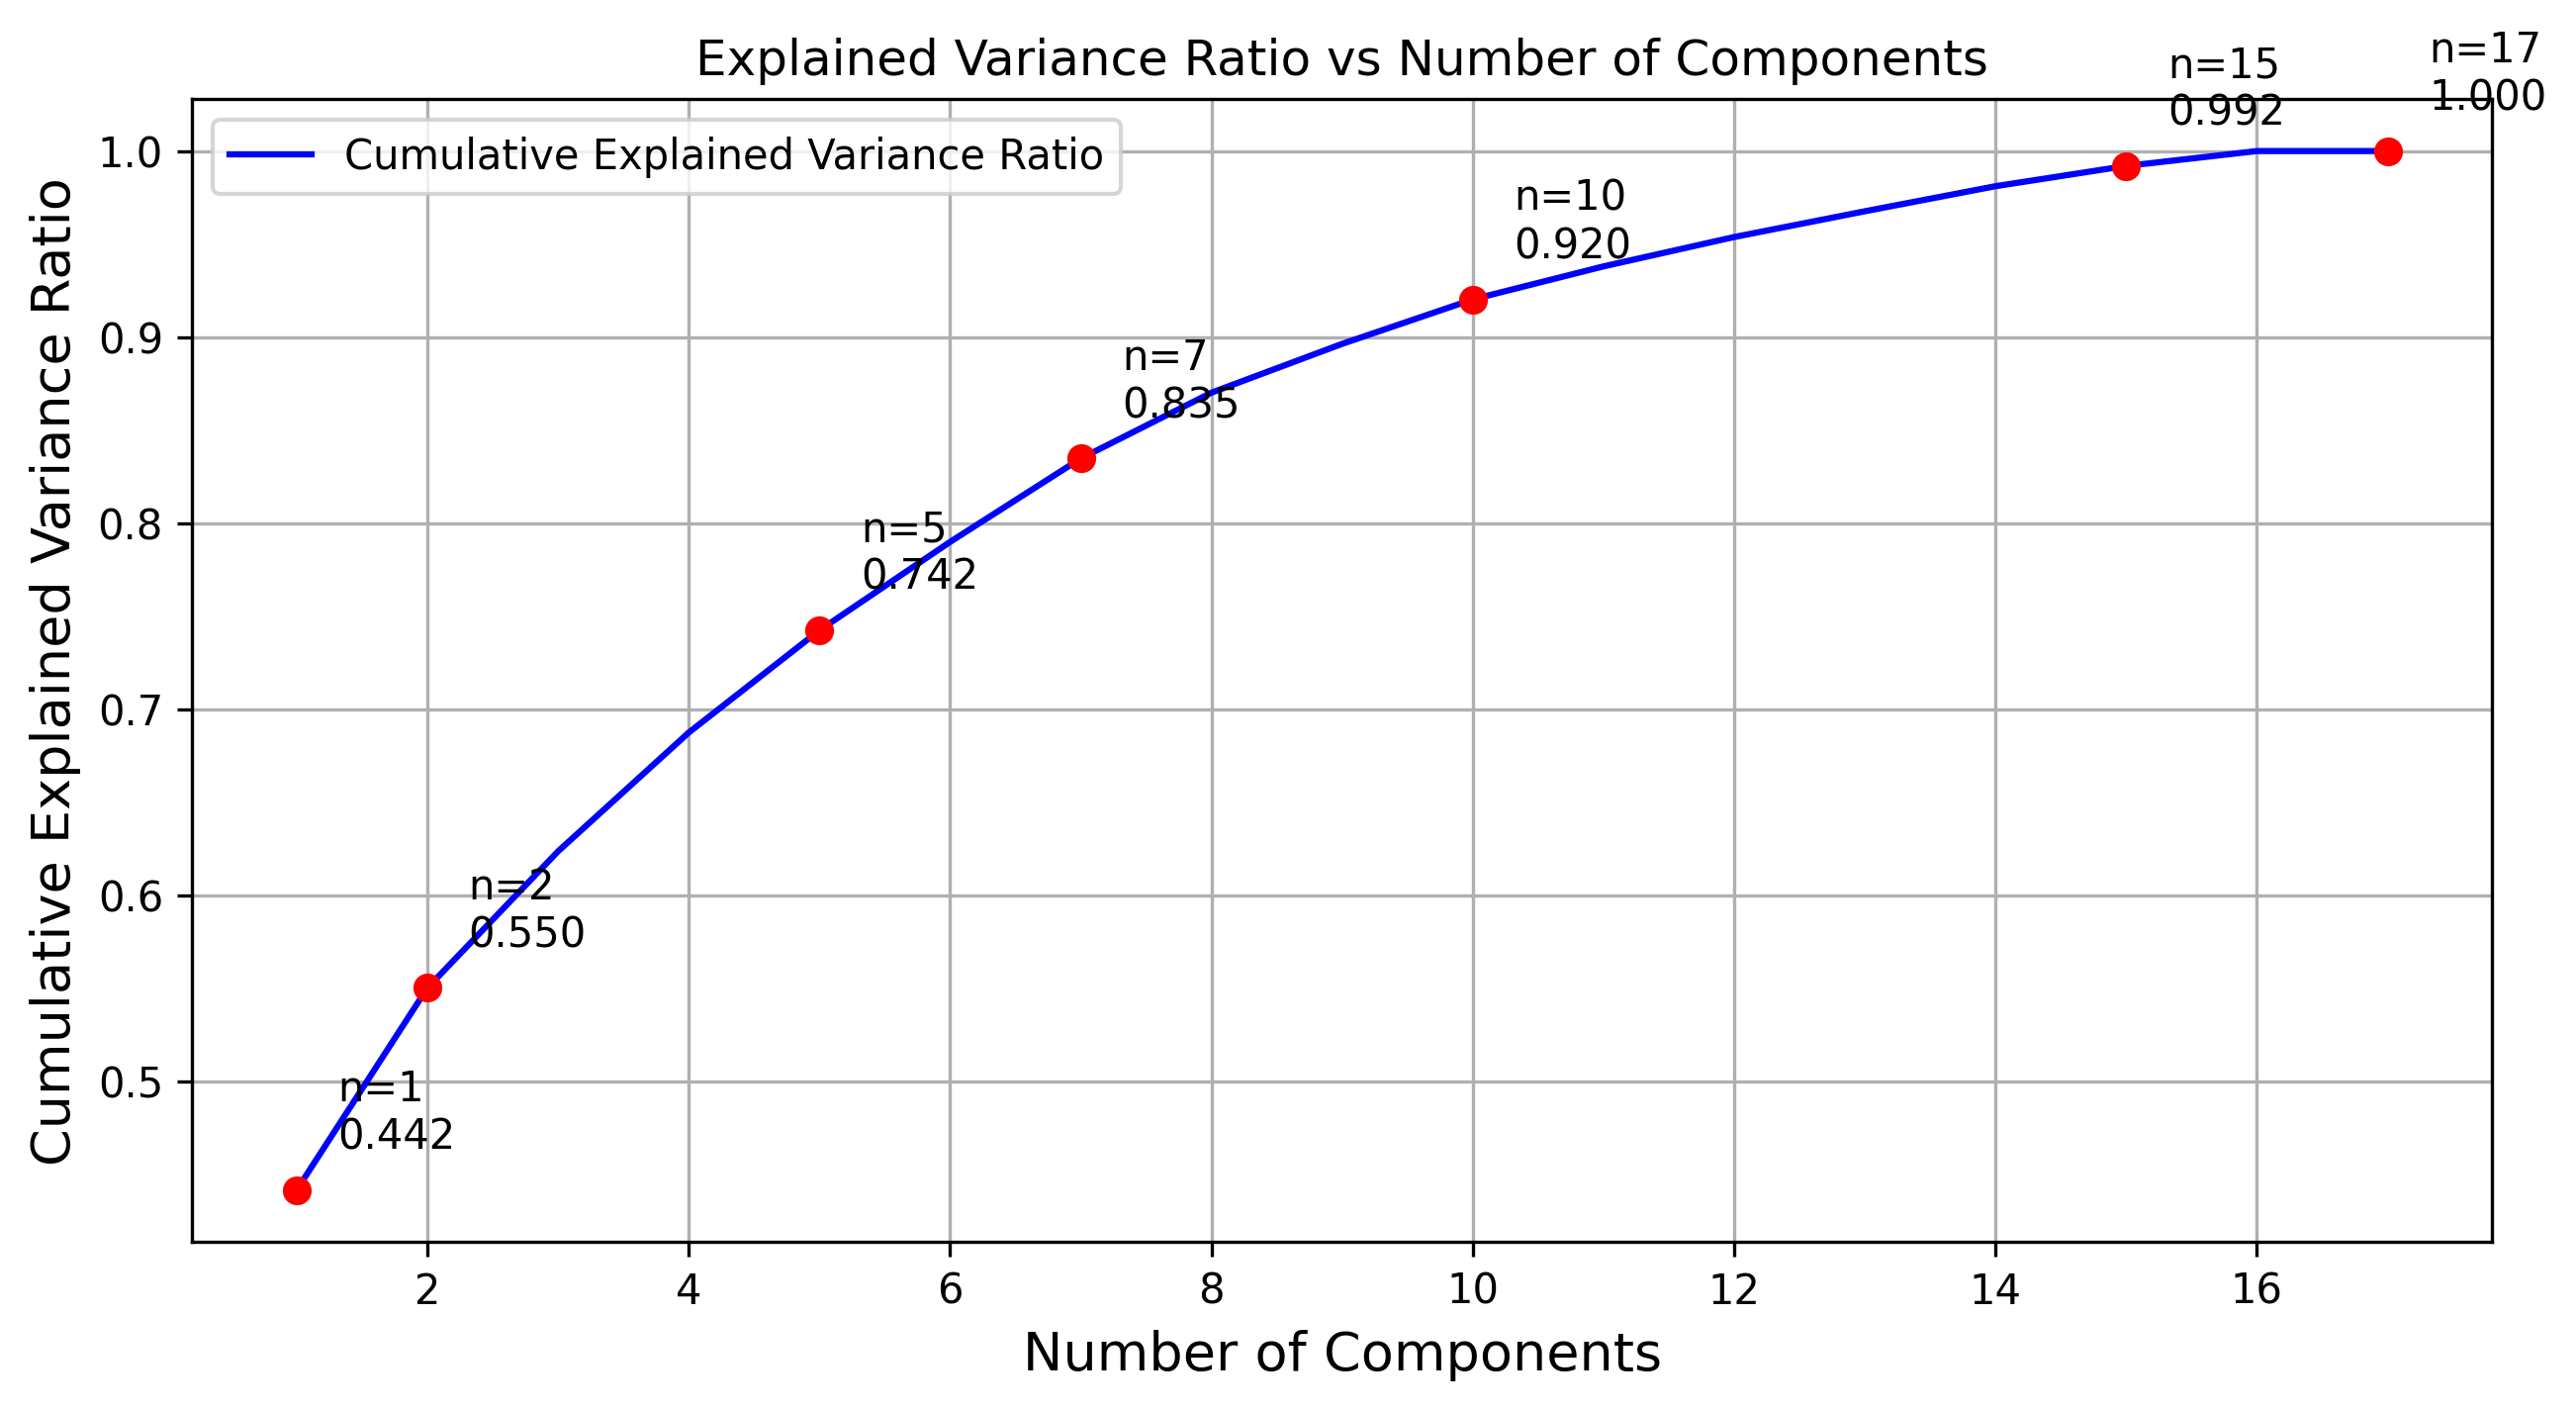


Variance ratio retained with different number of components:
n_components = 1: 44.15%
n_components = 2: 55.01%
n_components = 5: 74.24%
n_components = 7: 83.47%
n_components = 10: 92.03%
n_components = 15: 99.20%
n_components = 17: 100.00%


<Figure size 640x480 with 0 Axes>

In [18]:
n_components_max = 17
pca = PCA(n_components_max)
pca.fit(X_scaler)

cum_var_ratio = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(range(1, n_components_max + 1), cum_var_ratio, 'b-', label='Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=13)
plt.title('Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.legend()

for n in [1, 2, 5, 7, 10, 15, 17]:
    plt.plot(n, cum_var_ratio[n-1], 'ro')
    plt.annotate(f'n={n}\n{cum_var_ratio[n-1]:.3f}', 
                xy=(n, cum_var_ratio[n-1]), 
                xytext=(10, 10),
                textcoords='offset points')

plt.show()

print("\nVariance ratio retained with different number of components:")
for n in [1, 2, 5, 7, 10, 15, 17]:
    print(f"n_components = {n}: {cum_var_ratio[n-1]*100:.2f}%")

plt.savefig('fig2.png', dpi=300, bbox_inches='tight')

* Autoencoder reduces dimensionality by learning a concise hidden space representation (encoding) with the help of neural networks, often through data reconstruction.

In [19]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# List of encoding_dim values to experiment with
encoding_dims = [2, 5, 7, 10, 15, 19]

# Variable to store reconstruction losses
autoencoder_losses = []

# Size of the input
input_dim = X_scaler.shape[1]

# Iterate over each encoding_dim
for encoding_dim in encoding_dims:
    print(f"Training Autoencoder with encoding_dim = {encoding_dim}")

    # Build the Autoencoder model
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the Autoencoder
    history = autoencoder.fit(
        X_scaler, X_scaler,  # Input data and labels are the same
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_split=0.2,
        verbose=0  # Do not display the training process
    )

    # Get the loss value on the validation set from the training history
    val_loss = min(history.history['val_loss'])  # Best loss on validation data
    autoencoder_losses.append(val_loss)

    print(f"Encoding dim: {encoding_dim}, Validation Loss: {val_loss}")


Training Autoencoder with encoding_dim = 2
Encoding dim: 2, Validation Loss: 0.5961284041404724
Training Autoencoder with encoding_dim = 5
Encoding dim: 5, Validation Loss: 0.5407108664512634
Training Autoencoder with encoding_dim = 7
Encoding dim: 7, Validation Loss: 0.5135054588317871
Training Autoencoder with encoding_dim = 10
Encoding dim: 10, Validation Loss: 0.49679213762283325
Training Autoencoder with encoding_dim = 15
Encoding dim: 15, Validation Loss: 0.4811871647834778
Training Autoencoder with encoding_dim = 19
Encoding dim: 19, Validation Loss: 0.4713973104953766


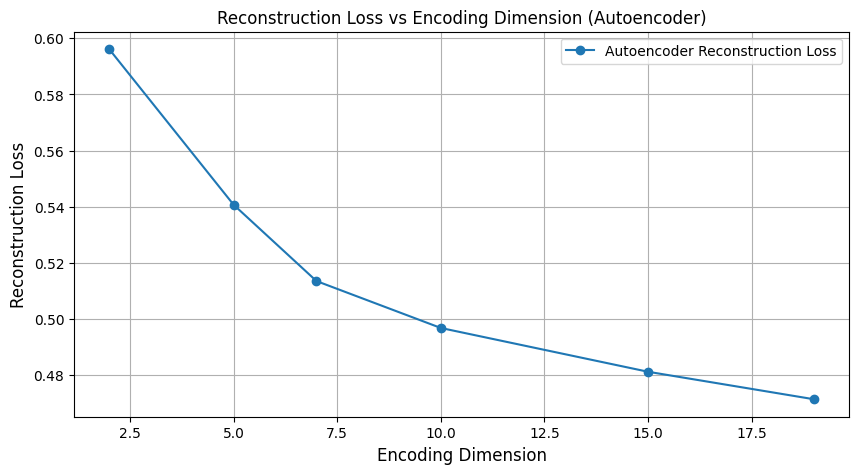

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(encoding_dims, autoencoder_losses, marker='o', label='Autoencoder Reconstruction Loss')
plt.xlabel('Encoding Dimension', fontsize=12)
plt.ylabel('Reconstruction Loss', fontsize=12)
plt.title('Reconstruction Loss vs Encoding Dimension (Autoencoder)')
plt.grid(True)
plt.legend()
plt.show()

### 3.2 Choose component for 2 algorithm

In [21]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaler)

* And for the comparison of the 2 dimensionality reduction algorithms, we also choose the dimension for the autoencoder to be 7 for easy reference and comparison.


In [22]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

input_dim = X_scaler.shape[1]
encoding_dim = 7

# Build Autoencoder
input_layer = Input(shape=(input_dim,))

encoded = Dense(encoding_dim, activation='relu', name="encoder")(input_layer)
# encoded = Dense(encoding_dim, activation='relu', 
#                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
#                 name="encoder")(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)


autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer=Adam(), loss='mse')
#autoencoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse')


autoencoder.fit(X_scaler, X_scaler, epochs=50, batch_size=32, shuffle=False)

#encoder = Model(autoencoder.input, autoencoder.layers[1].output)
encoder = Model(autoencoder.input, autoencoder.get_layer("encoder").output)
X_encoded = encoder.predict(X_scaler)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9477 
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8718
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7939
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7119
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6514
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6098
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5811
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5619
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5482
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5373
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5283
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5206
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5141
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5086
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5039
Epoch 16/50
70/70 

### 3.3 Compare Reconstruction of 2 algorithm dimension reducing

In [23]:
X_pca_projected = pca.inverse_transform(pca.transform(X_scaler))
pca_loss = np.mean(np.square(X_scaler - X_pca_projected))
print(f"PCA Reconstruction Loss: {pca_loss}")


PCA Reconstruction Loss: 0.12339463768475711


### 3.4 Visualization

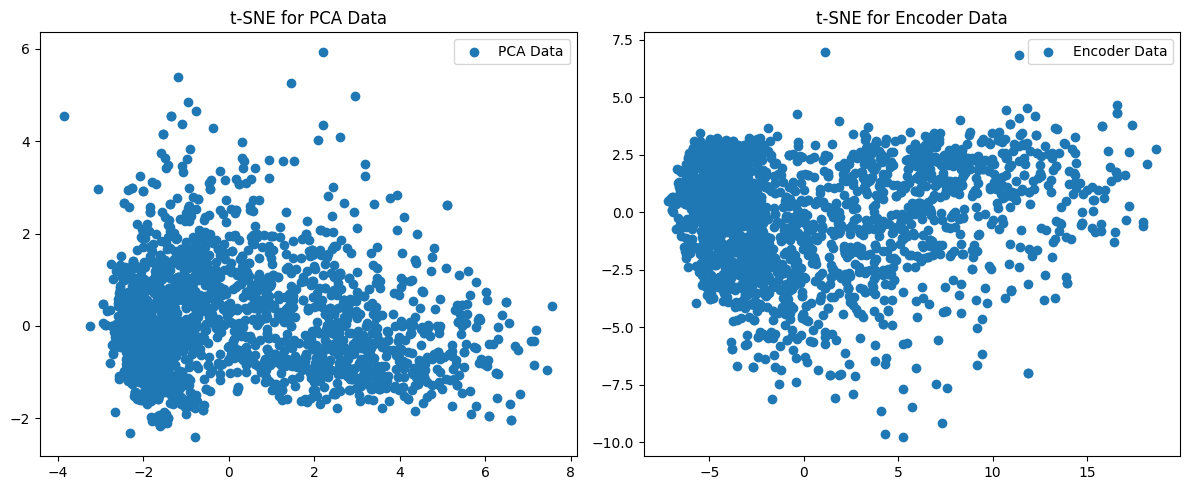

In [24]:
# Fit and transform for PCA data
from sklearn.manifold import TSNE
model_pca = PCA(n_components=2)
tsne_pca = model_pca.fit_transform(X_pca)

# Fit and transform for Encoder data
model_encoder = PCA(n_components=2)
tsne_encoder = model_encoder.fit_transform(X_encoded)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_pca[:, 0], tsne_pca[:, 1], label='PCA Data')
plt.title('t-SNE for PCA Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(tsne_encoder[:, 0], tsne_encoder[:, 1], label='Encoder Data')
plt.title('t-SNE for Encoder Data')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Use DBSCAN filltering outlier before k-mean

### 4.1 Choose eps optimize for DBSCAN

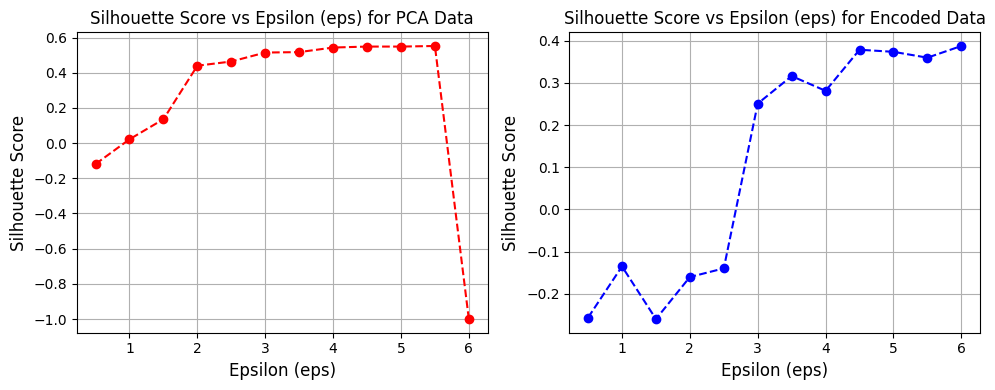

In [25]:
# Iterate over different eps values to find the optimal value
eps_values = np.arange(0.5, 6.5, 0.5)  # Test values from 0.5 to 5.5
silhouette_scores_encoded = []
silhouette_scores_pca = []

for eps in eps_values:
    # For PCA data
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(X_pca)

    if len(set(labels)) > 1:
        score = silhouette_score(X_pca, labels)
        silhouette_scores_pca.append(score)
    else:
        silhouette_scores_pca.append(-1)

    # For encoded data
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(X_encoded)

    # Skip the case where all points are assigned -1 (outliers)
    if len(set(labels)) > 1:
        score = silhouette_score(X_encoded, labels)
        silhouette_scores_encoded.append(score)
    else:
        silhouette_scores_encoded.append(-1)  # Assign -1 to not affect the result

# Plot the graph
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(eps_values, silhouette_scores_pca, marker='o', linestyle='dashed', color='r')
plt.xlabel("Epsilon (eps)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Score vs Epsilon (eps) for PCA Data")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouette_scores_encoded, marker='o', linestyle='dashed', color='b')
plt.xlabel("Epsilon (eps)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Score vs Epsilon (eps) for Encoded Data")
plt.grid()

plt.tight_layout()
plt.show()

In [26]:
dbscan = DBSCAN(eps=5, min_samples=5)
df["Cluster_label_Encoder"] = dbscan.fit_predict(X_encoded)
X_encoded_filtered = X_encoded[df["Cluster_label_Encoder"] != -1]
print(pd.DataFrame(df["Cluster_label_Encoder"]).value_counts())

Cluster_label_Encoder
 0                       2208
-1                          8
Name: count, dtype: int64


In [27]:
dbscan = DBSCAN(eps=5, min_samples=5)
df["Cluster_label_Pca"] = dbscan.fit_predict(X_pca)
X_pca_filtered = X_pca[df["Cluster_label_Pca"] != -1]
print(pd.DataFrame(df["Cluster_label_Pca"]).value_counts())

Cluster_label_Pca
 0                   2212
-1                      4
Name: count, dtype: int64


In [28]:
df[df["Cluster_label_Pca"] == -1]

,ID,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Family_Size,Cluster_label_Encoder,Cluster_label_Pca
21,5376,2,2447.0,1,0,42,1,1,1725,1,1,1,15,0,28,0,1,3,-1,-1
164,8475,2,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,3,-1,-1
687,1501,2,160803.0,0,0,21,55,16,1622,17,3,4,15,0,28,1,0,2,-1,-1
2233,9432,2,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,3,-1,-1


In [29]:
df[df["Cluster_label_Encoder"] == -1]

,ID,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Family_Size,Cluster_label_Encoder,Cluster_label_Pca
21,5376,2,2447.0,1,0,42,1,1,1725,1,1,1,15,0,28,0,1,3,-1,-1
164,8475,2,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,3,-1,-1
687,1501,2,160803.0,0,0,21,55,16,1622,17,3,4,15,0,28,1,0,2,-1,-1
855,1456,1,60474.0,0,1,25,265,199,303,234,9,170,7,10,2,12,7,2,-1,0
1328,4246,1,6560.0,0,0,2,67,11,26,4,3,262,0,1,0,1,17,1,-1,0
1480,2849,1,60474.0,0,1,25,265,199,303,234,9,170,7,10,2,12,7,2,-1,0
1653,4931,2,157146.0,0,0,13,1,0,1725,2,1,1,0,0,28,0,1,2,-1,0
2233,9432,2,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,3,-1,-1


* Here we choose KNN to analyze the outliers filtered by DBSCAN because KNN will help us identify outliers effectively with this dataset. When normalized using Robust Scaler, the distances between data points and cluster centers increase, making the outliers more apparent. If the noise points have a much higher average k-distance compared to the main data region, it proves that DBSCAN has reasonably identified the outliers.


And to choose k so that the error calculation of the two algorithms is effective, keeping the smallest k value for both datasets of the two dimensionality reduction algorithms
* Note: The value of k will be limited by the smaller set and knn can only be used when the outlier filter has at least 2 data points

Mean k-Distance for PCA outliers: 3.81
Mean k-Distance for PCA main clusters: 0.76
Mean k-Distance for Encoder outliers: 11.23
Mean k-Distance for Encoder main clusters: 1.54


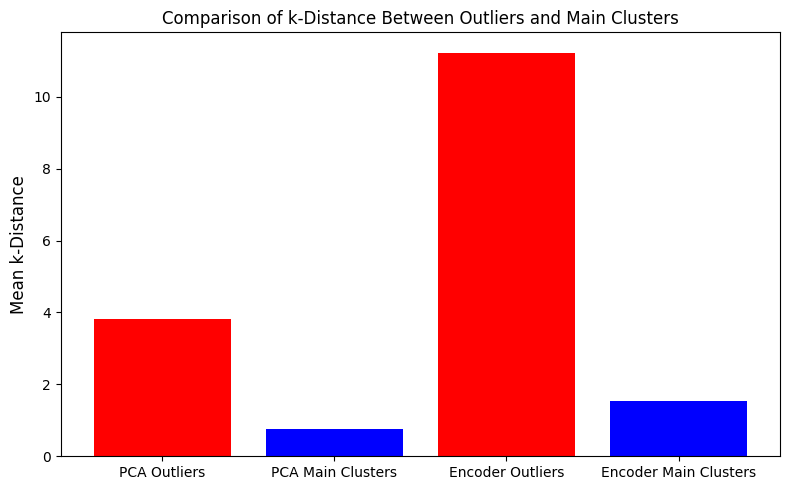

In [30]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Separate PCA data
pca_outliers = X_pca[df["Cluster_label_Pca"] == -1]
pca_main_clusters = X_pca[df["Cluster_label_Pca"] != -1]

# Separate Encoded data
encoder_outliers = X_encoded[df["Cluster_label_Encoder"] == -1]
encoder_main_clusters = X_encoded[df["Cluster_label_Encoder"] != -1]

# Set k for k-Distance calculation
k = min(len(pca_outliers) - 1, len(encoder_outliers) - 1)

# Calculate k-Distance for PCA outliers
neighbors_pca_outliers = NearestNeighbors(n_neighbors=k).fit(pca_outliers)
distances_pca_outliers, _ = neighbors_pca_outliers.kneighbors(pca_outliers)
mean_k_distance_pca_outliers = distances_pca_outliers[:, -1].mean()

# Calculate k-Distance for PCA main clusters
neighbors_pca_clusters = NearestNeighbors(n_neighbors=k).fit(pca_main_clusters)
distances_pca_clusters, _ = neighbors_pca_clusters.kneighbors(pca_main_clusters)
mean_k_distance_pca_clusters = distances_pca_clusters[:, -1].mean()


# Calculate k-Distance for Autoencoder outliers
neighbors_encoder_outliers = NearestNeighbors(n_neighbors=k).fit(encoder_outliers)
distances_encoder_outliers, _ = neighbors_encoder_outliers.kneighbors(encoder_outliers)
mean_k_distance_encoder_outliers = distances_encoder_outliers[:, -1].mean()

# Calculate k-Distance for Autoencoder main clusters
neighbors_encoder_clusters = NearestNeighbors(n_neighbors=k).fit(encoder_main_clusters)
distances_encoder_clusters, _ = neighbors_encoder_clusters.kneighbors(encoder_main_clusters)
mean_k_distance_encoder_clusters = distances_encoder_clusters[:, -1].mean()

# Bar chart for visualization
labels = ['PCA Outliers', 'PCA Main Clusters', 'Encoder Outliers', 'Encoder Main Clusters']
mean_distances = [
    mean_k_distance_pca_outliers, mean_k_distance_pca_clusters,
    mean_k_distance_encoder_outliers, mean_k_distance_encoder_clusters
]

print(f"Mean k-Distance for PCA outliers: {mean_k_distance_pca_outliers:.2f}")
print(f"Mean k-Distance for PCA main clusters: {mean_k_distance_pca_clusters:.2f}")
print(f"Mean k-Distance for Encoder outliers: {mean_k_distance_encoder_outliers:.2f}")
print(f"Mean k-Distance for Encoder main clusters: {mean_k_distance_encoder_clusters:.2f}")

plt.figure(figsize=(8, 5))
plt.bar(labels, mean_distances, color=['red', 'blue', 'red', 'blue'])
plt.ylabel('Mean k-Distance', fontsize=12)
plt.title('Comparison of k-Distance Between Outliers and Main Clusters')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(pca_outliers, pca_main_clusters)
print(" Average distance from outliers to inliers:", distances.mean())


 Average distance from outliers to inliers: 9.136183863478088


### 4.2 Evaluate and choose k cluster for K-means

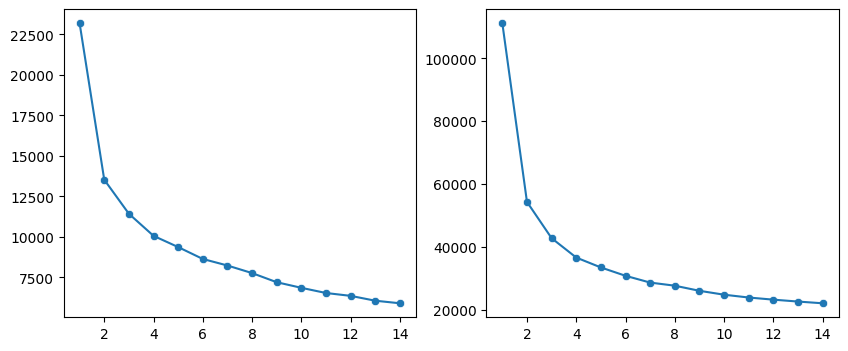

In [32]:
error_pca = []
error_encoder = []
for n_clusters in range(1, 15):
    model_pca = KMeans(init='k-means++',
                    n_clusters=n_clusters,
                    max_iter=500,
                    random_state=42)
    model_encoder = KMeans(init='k-means++',
                        n_clusters=n_clusters,
                        max_iter=500,
                        random_state=42)
    model_pca.fit(X_pca_filtered)
    model_encoder.fit(X_encoded_filtered)
    error_pca.append(model_pca.inertia_)
    error_encoder.append(model_encoder.inertia_)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sb.lineplot(x=range(1, 15), y=error_pca)
sb.scatterplot(x=range(1, 15), y=error_pca)

plt.subplot(1, 2, 2)
sb.lineplot(x=range(1, 15), y=error_encoder)
sb.scatterplot(x=range(1, 15), y=error_encoder)

plt.show()

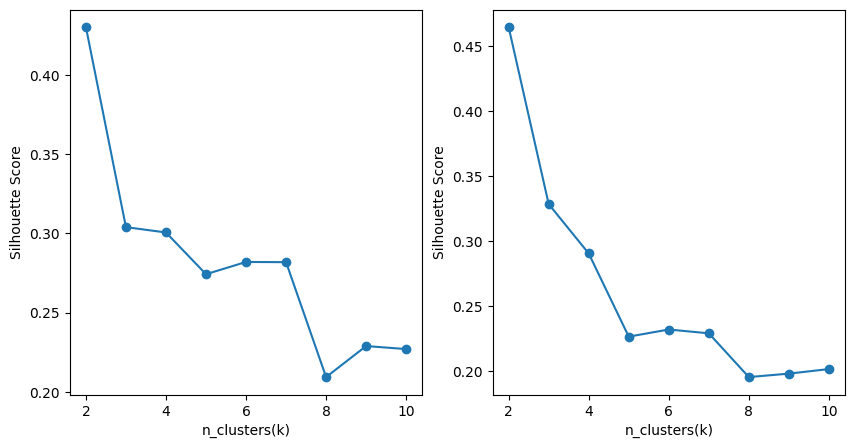

In [33]:
silhouette_scores_pca = []
silhouette_scores_encoded = []
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_filtered)
    silhouette_scores_pca.append(silhouette_score(X_pca_filtered, cluster_labels))

for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_encoded_filtered)
    silhouette_scores_encoded.append(silhouette_score(X_encoded_filtered, cluster_labels))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), silhouette_scores_pca, marker='o')
plt.xlabel('n_clusters(k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_encoded, marker='o')
plt.xlabel('n_clusters(k)')
plt.ylabel('Silhouette Score')
plt.show()



In [34]:
model_pca = KMeans(init="k-means++",n_clusters=3,max_iter=500,random_state=42)
segments_pca = model_pca.fit_predict(X_pca_filtered)
df.loc[df["Cluster_label_Pca"] == 0, "Cluster_label_Pca"] = segments_pca
model_pca.n_iter_

37

In [35]:
model_encoder = KMeans(init="k-means++",n_clusters=3,max_iter=500,random_state=42)
segments_encoder = model_encoder.fit_predict(X_encoded_filtered)
df.loc[df["Cluster_label_Encoder"] == 0, "Cluster_label_Encoder"] = segments_encoder
model_encoder.n_iter_

8

## 5. Visualization

Text(0.5, 1.0, 'K-Means on dimensionally reduced data using Autoencoder')

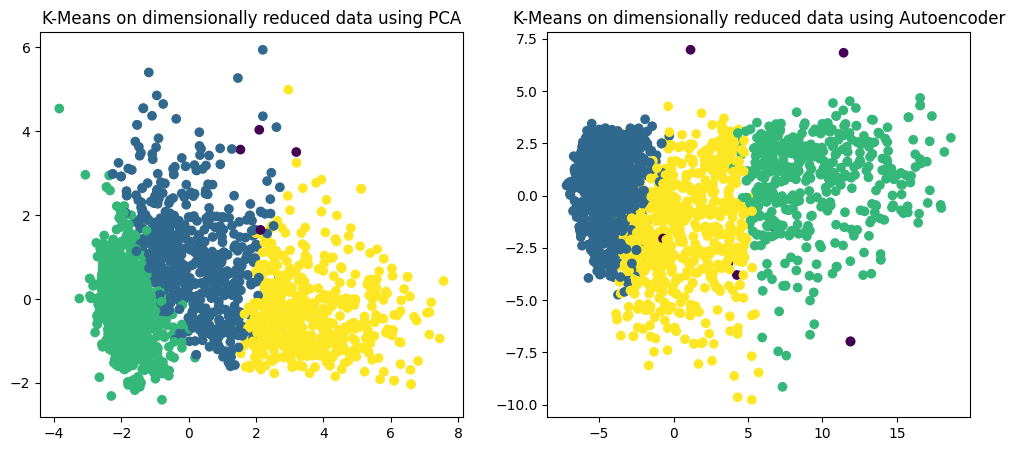

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=df["Cluster_label_Pca"], cmap='viridis', label='Centroids')
ax[0].set_title("K-Means on dimensionally reduced data using PCA")


ax[1].scatter(tsne_encoder[:, 0], tsne_encoder[:, 1], c=df["Cluster_label_Encoder"], cmap='viridis', label='Centroids')
ax[1].set_title("K-Means on dimensionally reduced data using Autoencoder")


In [37]:
import plotly.express as px

df_tsne = pd.DataFrame({'x': tsne_pca[:, 0], 'y': tsne_pca[:, 1], 'segment':df['Cluster_label_Pca']})
# Create 3D PCA visualization
fig = px.scatter_3d(
    df_tsne,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z = X_pca[:, 2],
    color=df['Cluster_label_Pca'].astype(str),
    title="3D PCA Cluster Visualization",
    labels={'color': 'Cluster'}
)
fig.show()



In [38]:
import plotly.express as px

df_tsne = pd.DataFrame({'x': tsne_encoder[:, 0], 'y': tsne_encoder[:, 1], 'segment':df['Cluster_label_Encoder']})
# Create 3D PCA visualization
fig = px.scatter_3d(
    df_tsne,
    x=X_encoded[:, 0],
    y=X_encoded[:, 1],
    z = X_encoded[:, 2],
    color=df['Cluster_label_Encoder'].astype(str),
    title="3D PCA Cluster Visualization",
    labels={'color': 'Cluster'}
)
fig.show()

In [39]:
print("Inertia (WCSS) of K-Means on dimensionally reduced data using PCA:", model_pca.inertia_)
print("Inertia (WCSS) of K-Means on dimensionally reduced data using Autoencoder:", model_encoder.inertia_)

Inertia (WCSS) of K-Means on dimensionally reduced data using PCA: 11422.848065479915
Inertia (WCSS) of K-Means on dimensionally reduced data using Autoencoder: 42740.078125


In [40]:
from sklearn.metrics import davies_bouldin_score
print("Davies-Bouldin Index of K-Means on dimensionally reduced data using PCA:",davies_bouldin_score(X_pca_filtered, segments_pca))
print("Davies-Bouldin Index of K-Means on dimensionally reduced data using Autoencoder:",davies_bouldin_score(X_encoded_filtered, segments_encoder))

Davies-Bouldin Index of K-Means on dimensionally reduced data using PCA: 1.408749432932791
Davies-Bouldin Index of K-Means on dimensionally reduced data using Autoencoder: 1.2371764812256612


Analysis of Differences

1. Silhouette Score

- In 3 clusters, the right chart (Autoencoder) has a higher Silhouette Score compared to PCA.
This indicates that Autoencoder helps K-Means cluster better, with larger distances between clusters and less overlap.
The trend decreases as the number of clusters increases.

- Both methods show a decreasing Silhouette Score as the number of clusters increases.
However, Autoencoder maintains a higher level compared to PCA in most k values.

Conclusion: Autoencoder helps K-Means separate clusters more clearly than PCA.

2. Inertia (WCSS)

PCA: 11422.848065479904

Autoencoder: 42740.0703125

Observations:

- The Inertia (WCSS) value of Autoencoder is higher than PCA.
- Inertia measures the total squared distance from each data point to the nearest cluster center.
- Autoencoder gives a higher Inertia value, which may be due to the data after dimensionality reduction by Autoencoder still maintaining better separation between clusters, leading to larger distances between points and cluster centers.

Conclusion: Autoencoder may help retain more important features for K-Means, rather than simply compressing data in a linear way like PCA.

3. Davies-Bouldin Index (DBI)

PCA: 1.4087494329327903

Autoencoder: 1.2371764649355976

Observations:

- The Davies-Bouldin Index (DBI) of Autoencoder is lower than PCA.
- The lower the DBI, the clearer and better separated the clusters are.
- Autoencoder has a better DBI than PCA, meaning the clusters of K-Means after dimensionality reduction by Autoencoder have better separation.

Conclusion: Autoencoder helps K-Means cluster better than PCA, as it retains the nonlinear structure of the data.

**Summary**: Autoencoder is better than PCA for dimensionality reduction before K-Means
- PCA only uses linear transformations, losing important information in complex data.
- Autoencoder can learn nonlinear features, helping K-Means cluster more effectively.
- If the data has a nonlinear structure, Autoencoder is a better choice for dimensionality reduction before K-Means.

## 6. Analysis for each clustering

### Analysis customer segmentation

In [41]:
df.drop(columns=["Cluster_label_Pca"],axis=1, inplace= True)

In [42]:
df = df[df['Cluster_label_Encoder'] != -1]

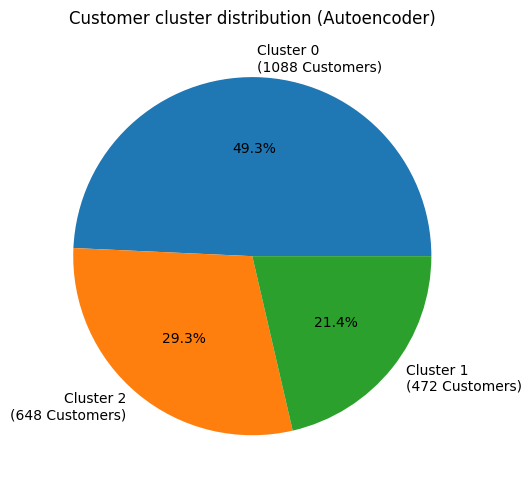

In [43]:
plt.figure(figsize=(12,5))

encoder_counts = df['Cluster_label_Encoder'].value_counts()
plt.pie(encoder_counts, labels=[f'Cluster {i}\n({v} Customers)' for i,v in encoder_counts.items()], autopct='%1.1f%%')
plt.title('Customer cluster distribution (Autoencoder)')

plt.tight_layout()
plt.show()

In [44]:
df["Total Amounts"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

df["Total Purchase"] = df["NumDealsPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"] + df["NumWebPurchases"] + df["NumWebVisitsMonth"]

df = df[df["Total Purchase"] != 0]

df["Amount_1_Time"] = np.ceil(df['Total Amounts'] / (df["Total Purchase"]))

df = df[df["Cluster_label_Encoder"] != -1]

In [45]:
cluster_summary = df.groupby("Cluster_label_Encoder").mean()
cluster_sum = df.groupby("Cluster_label_Encoder").sum()

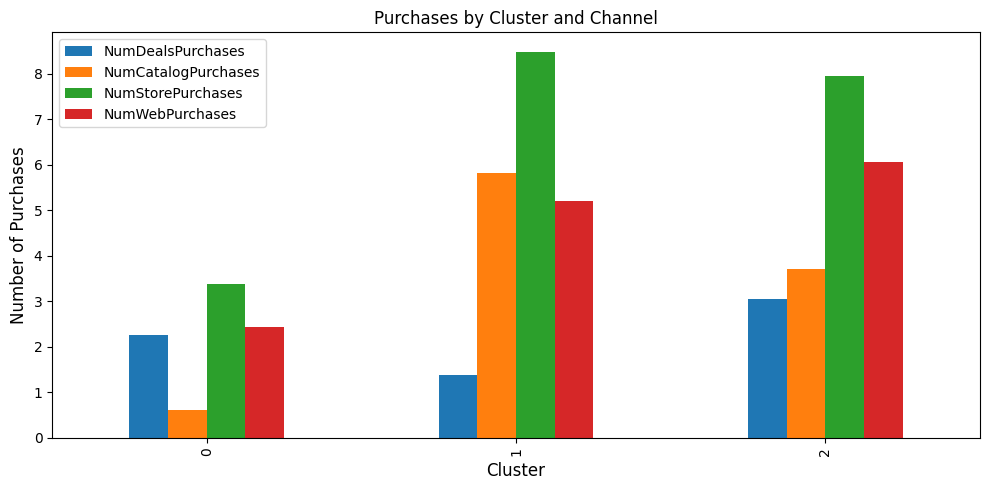

In [46]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

cluster_summary[["NumDealsPurchases","NumCatalogPurchases", 'NumStorePurchases', "NumWebPurchases"]].plot(kind='bar', ax=ax1)
ax1.set_title('Purchases by Cluster and Channel')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Number of Purchases', fontsize=12)
plt.tight_layout()
plt.show()

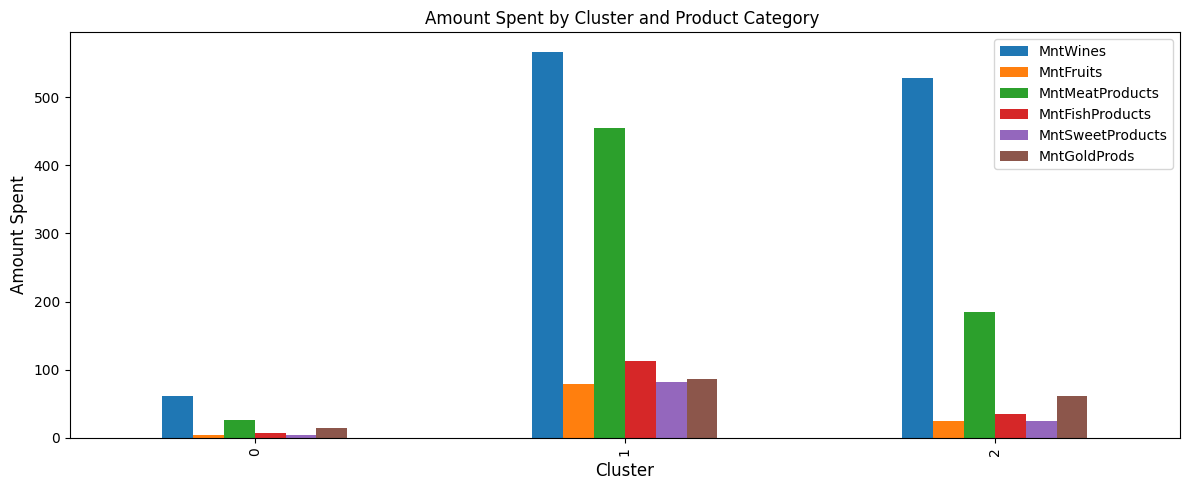

In [47]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

cluster_summary[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].plot(kind='bar', ax=ax1)
ax1.set_title('Amount Spent by Cluster and Product Category ')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Amount Spent', fontsize=12)
plt.tight_layout()
plt.show()

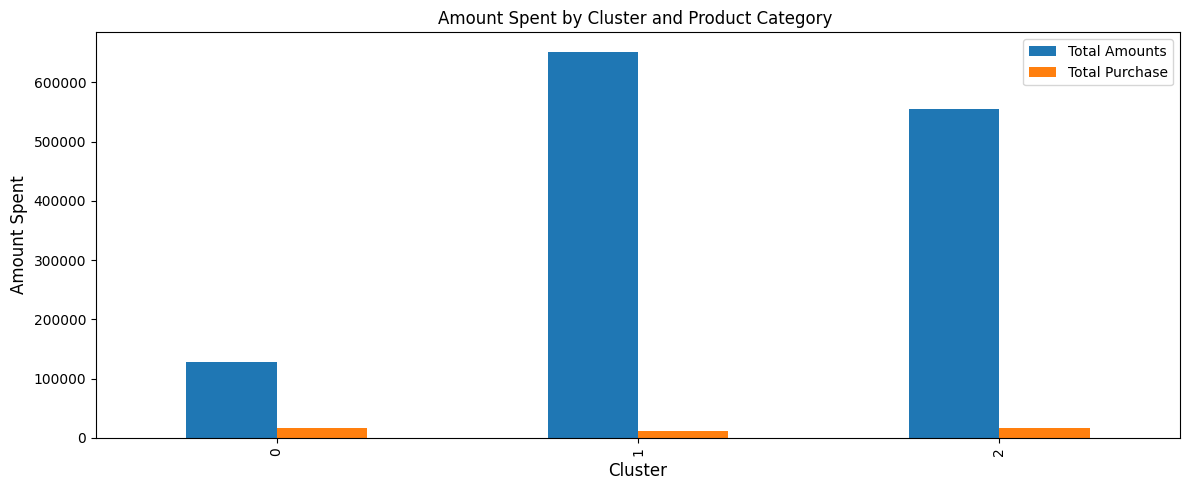

,Total Amounts,Total Purchase
Cluster_label_Encoder,,
0,128364,16561
1,652037,11199
2,555284,16737


In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

cluster_sum[['Total Amounts','Total Purchase']].plot(kind='bar', ax=ax1)
ax1.set_title('Amount Spent by Cluster and Product Category ')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Amount Spent', fontsize=12)
plt.tight_layout()
plt.show()

cluster_sum[['Total Amounts','Total Purchase']].round().astype(int)

In [49]:
cluster_summary[['Income','Recency','Total Amounts','Total Purchase']].round().astype(int)

,Income,Recency,Total Amounts,Total Purchase
Cluster_label_Encoder,,,,
0,35675,50,118,15
1,75287,48,1381,24
2,61643,48,858,26


### Clustering Customer(Vip, Loyal, Normally)

In [50]:
highest_avg_column = ['Total Amounts', 'Total Purchase']
potential_clusters = cluster_summary.sort_values(by=highest_avg_column, ascending=False)

# Print the cluster with the highest spending based on the selected column
print("V.I.P customer cluster:", potential_clusters.index[0])
print("Loyal customer cluster:", potential_clusters.index[1])
print("Normally customer cluster:", potential_clusters.index[2])

V.I.P customer cluster: 1
Loyal customer cluster: 2
Normally customer cluster: 0


### Customers tend to leave

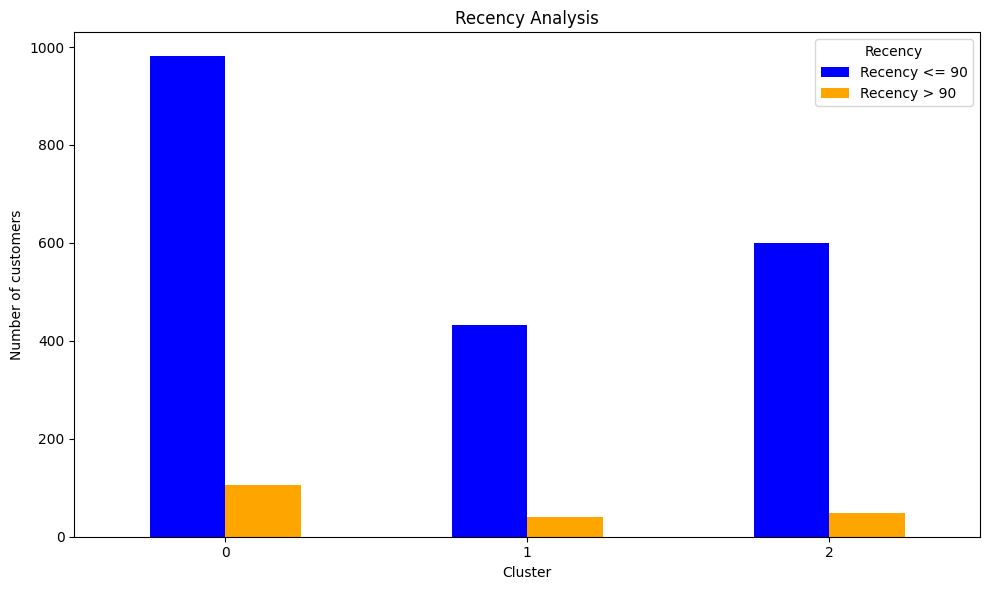

In [51]:
def plot_recency_analysis(df, cluster_column, title):
    recency_data = []
    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        # Divide into 2 groups based on Recency
        recent_customers = cluster_data[cluster_data['Recency'] <= 90]
        old_customers = cluster_data[cluster_data['Recency'] > 90]
        # Add data to the list
        recency_data.append({'Cluster': cluster, 'Recency <= 90': len(recent_customers), 'Recency > 90': len(old_customers)})
    # Convert data to DataFrame
    recency_df = pd.DataFrame(recency_data)
    # Create a bar chart
    recency_df.set_index('Cluster').plot(kind='bar', stacked=False, color=['blue', 'orange'], figsize=(10, 6))
    # Add information to the chart
    plt.title(title)
    plt.ylabel('Number of customers')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.legend(title='Recency', labels=['Recency <= 90', 'Recency > 90'])
    plt.tight_layout()
    # Display the chart
    plt.show()

# Plot a bar chart for Recency analysis by Cluster_label_Encoder
plot_recency_analysis(df, 'Cluster_label_Encoder', 'Recency Analysis')

In [52]:
print("Phân tích theo Recency:")
for cluster in df['Cluster_label_Encoder'].unique():
    cluster_data = df[df['Cluster_label_Encoder'] == cluster]

    # Divide into 2 groups based on Recency
    recent_customers = cluster_data[cluster_data['Recency'] <= 90]
    old_customers = cluster_data[cluster_data['Recency'] > 90]

    print(f"\nCluster {cluster}:")
    print(f"Number of customers have recency <= 90: {len(recent_customers)}")
    print(f"Number of customers have recency > 90: {len(old_customers)}")

Phân tích theo Recency:

Cluster 1:
Number of customers have recency <= 90: 432
Number of customers have recency > 90: 40

Cluster 0:
Number of customers have recency <= 90: 981
Number of customers have recency > 90: 106

Cluster 2:
Number of customers have recency <= 90: 599
Number of customers have recency > 90: 48


### Feature Important

In [53]:
feature = ['Income','Recency','Total Amounts','Total Purchase','Family_Size']

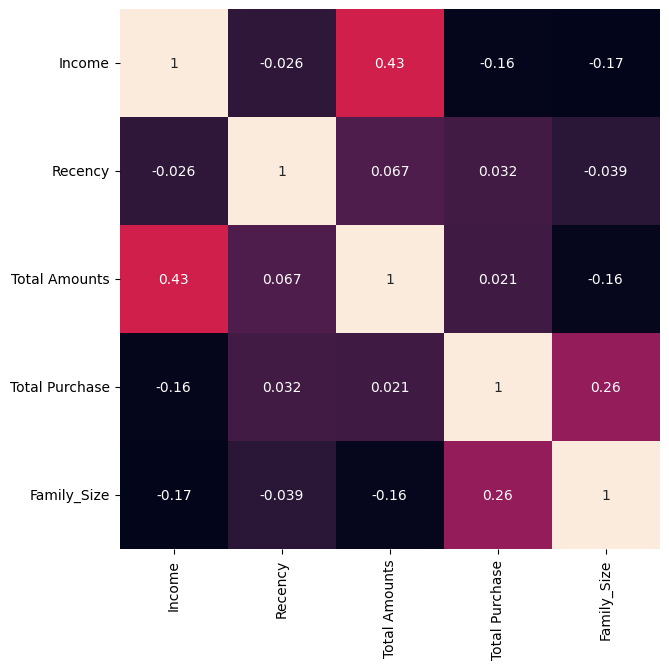

In [54]:
vip_customer = df[df["Cluster_label_Encoder"] == 1]
vct = vip_customer[feature]
plt.figure(figsize=(6, 6))
sb.heatmap(vct.corr(), annot=True, cbar=False)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
plt.show()

## 7. Predicting Potential Customers

#### 1. Problem
- **Cluster "Loyal" (Cluster 1)** consists of customers with "good" behavior, but only **"similar" to the VIP cluster (Cluster 2)** and not entirely part of the VIP group.

=> **"Potential to become VIP"** means finding within the loyal cluster **those customers who are close to VIP behavior**, but still have differences compared to VIP.

   - It is necessary to determine a **dynamic, reasonable threshold** to distinguish outstanding customers in the "Loyal" cluster from the majority of the loyal cluster, and close to the **VIP behavior boundary**.


#### 2. Set a Relative Threshold Based on Average Distance
- **Idea:** Calculate the distance between each point in the Loyal cluster and:
    - **Loyal centroid (C_Friendly)**.
    - **VIP centroid (C_VIP)**.

- Then, set a threshold:
    - If a customer belongs to the Loyal cluster but has a distance to the VIP centroid **smaller than a certain dynamic value (soft boundary threshold)**, the customer is labeled as "Potential".


Việc sử dụng **Min-Max Scaling** là một hướng tiếp cận tốt vì nó sẽ:
1. Chuẩn hóa các đặc trưng (feature) về mức **tương quan trên cùng một thang đo** (ví dụ: [0, 1]).
    - Điều này đặc biệt hữu ích khi các yếu tố khách hàng (như chi tiêu, tần suất mua hàng, số ngày kể từ lần mua gần nhất) có thang đo khác nhau.
    - Sau khi chuẩn hóa, bạn dễ dàng xác định "ngưỡng động" để chọn nhóm khách hàng có khả năng lên VIP.

2. **Tạo điểm số "tương đối"** cho mỗi khách hàng, giúp bạn chọn ngưỡng dựa trên thang đo chung.


### **Method: Identifying Potential VIP Customers**


#### **Step 1: Calculate Distance to VIP**
Based on behavioral indicators, Euclidean distance can be used to represent the proximity of each customer **to the VIP cluster**:


In [55]:
scaler = RobustScaler()
df_scale = scaler.fit_transform(df)

features = ['Income', 'Recency', 'Total Amounts', 'Total Purchase', 'Family_Size']

loyal_customers = df[df['Cluster_label_Encoder'] == 2]
vip_customers = df[df['Cluster_label_Encoder'] == 1]

In [56]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate the centroid of the Loyal (Friendly) and VIP clusters
loyal_centroid = loyal_customers[features].mean()
vip_centroid = vip_customers[features].mean()

# Distance from each customer to the two centroids (Loyal and VIP)
loyal_customers['dist_to_loyal'] = euclidean_distances(loyal_customers[features], [loyal_centroid]).flatten()
loyal_customers['dist_to_vip'] = euclidean_distances(loyal_customers[features], [vip_centroid]).flatten()


C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\2252241639.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\2252241639.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### **Step 2: Set Threshold Based on Distance**
Once we have the distances, we need a **threshold to identify customers close to VIP**:
1. First, calculate the **average distance of the loyal cluster to VIP (mean_distance_to_vip)**:
    - This is the "average" distance representing the overall loyal behavior.
    - Points closer to VIP than this threshold → _potential to become VIP_.

2. Increase flexibility by **incorporating the standard deviation of the distance** within the loyal cluster:
    - For example: **Mean - Std (or Mean - k×Std)** to adjust the detection threshold.


In [57]:
# Calculate the average distance and standard deviation within the loyal cluster
mean_dist_to_vip = loyal_customers['dist_to_vip'].mean()
std_dist_to_vip = loyal_customers['dist_to_vip'].std()

# Threshold to detect customers close to VIP: Mean - k×Std (with k = 1,2,...)
k = 1  # Deviation coefficient
vip_threshold_distance = mean_dist_to_vip - k * std_dist_to_vip

print(f"Threshold distance to VIP to identify potential: {vip_threshold_distance}")


Threshold distance to VIP to identify potential: 4964.784772374525


#### **Step 3: Label Potential VIP Customers**
- After setting the threshold (e.g., **Mean - Std**), identify all loyal customers whose distance to VIP is less than this threshold:


In [58]:
loyal_customers['potential_vip'] = (
        (loyal_customers['dist_to_vip'] <= vip_threshold_distance).astype(int) # Distance close to VIP
)

potential_vip_customers = loyal_customers[loyal_customers['potential_vip'] == 1]
potential_vip_customers


C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\4195587281.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,Family_Size,Cluster_label_Encoder,Total Amounts,Total Purchase,Amount_1_Time,dist_to_loyal,dist_to_vip,potential_vip
2,4141,2,71613.0,0,0,26,426,49,127,111,...,10,4,2,2,776,25,32.0,9970.061473,3723.758653,1
18,6565,2,76995.0,0,1,91,1012,80,498,0,...,9,5,3,2,1782,31,58.0,15379.527875,1754.746915,1
49,6566,2,72550.0,1,1,39,826,50,317,50,...,12,8,4,2,1319,36,37.0,10916.434882,2737.900743,1
69,1357,2,74854.0,1,2,90,856,59,487,58,...,5,5,5,2,1562,24,66.0,13229.498474,471.178744,1
125,1491,2,71488.0,0,0,87,162,33,124,40,...,7,1,2,2,559,17,33.0,9849.328022,3887.350082,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,3919,1,72309.0,0,0,64,960,0,883,50,...,8,3,1,2,1931,23,84.0,10719.524651,3028.471602,1
2145,9790,1,78499.0,0,0,12,912,72,170,47,...,4,4,1,2,1334,23,58.0,16862.449505,3212.403908,1
2173,6721,2,71965.0,0,1,21,572,19,286,50,...,5,3,3,2,1213,20,61.0,10327.829420,3326.523683,1
2186,2666,2,76234.0,0,1,21,519,50,167,130,...,11,3,3,2,907,26,35.0,14590.804477,1059.408211,1


#### Any customer belonging to the loyal cluster but whose distance to VIP is too close to the threshold boundary is a "potential VIP candidate.


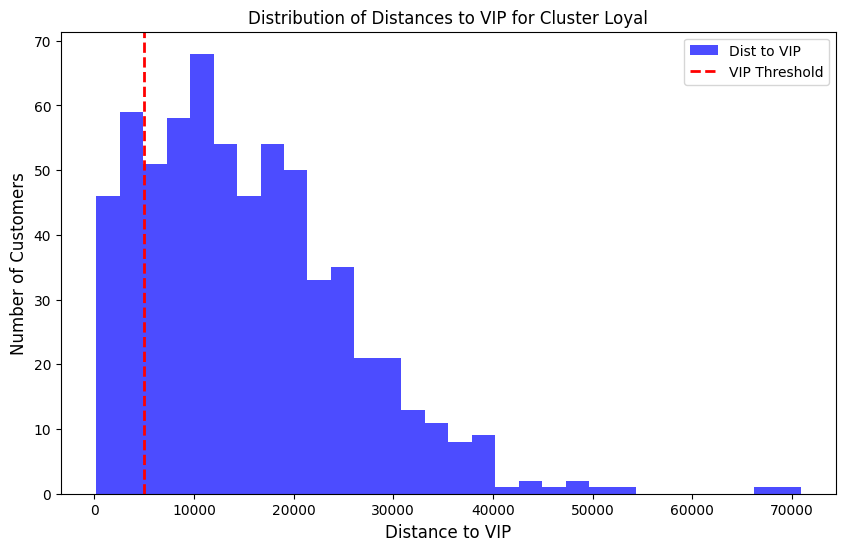

In [59]:
import matplotlib.pyplot as plt

# Visualize the distance of loyal customers to VIP
plt.figure(figsize=(10, 6))
plt.hist(loyal_customers['dist_to_vip'], bins=30, alpha=0.7, color='blue', label='Dist to VIP')
plt.axvline(vip_threshold_distance, color='red', linestyle='dashed', linewidth=2, label='VIP Threshold')
plt.xlabel('Distance to VIP', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Distances to VIP for Cluster Loyal')
plt.legend()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\144258499.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\144258499.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



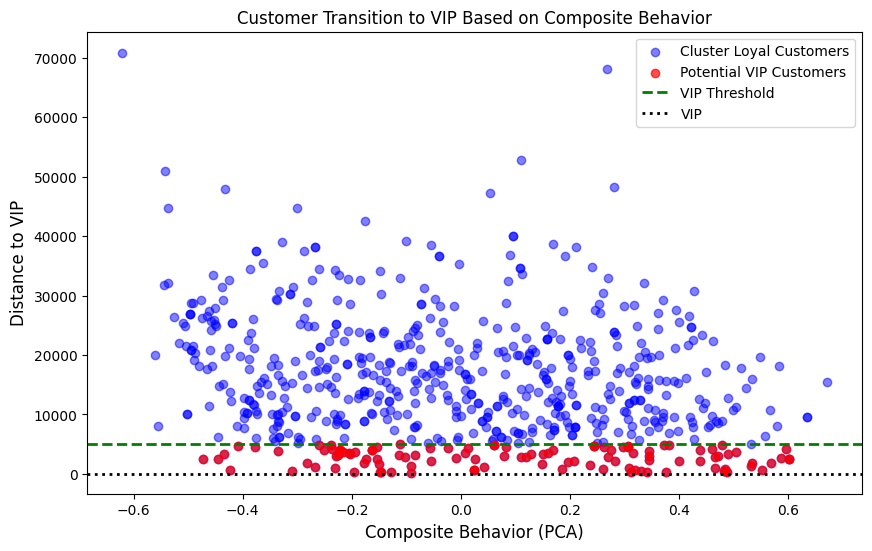

In [60]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(loyal_customers[features])

pca = PCA(n_components=1)
loyal_customers['Composite_Behavior'] = pca.fit_transform(scaled_data)

scaled_data_potential = scaler.transform(potential_vip_customers[features])
potential_vip_customers['Composite_Behavior'] = pca.transform(scaled_data_potential)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot data for Cluster Loyal Customers
plt.scatter(loyal_customers['Composite_Behavior'], loyal_customers['dist_to_vip'], 
            color='blue', alpha=0.5, label='Cluster Loyal Customers')

# Plot data for Potential VIP Customers
plt.scatter(potential_vip_customers['Composite_Behavior'], potential_vip_customers['dist_to_vip'], 
            color='red', alpha=0.7, label='Potential VIP Customers')


plt.axhline(vip_threshold_distance, color='green', linestyle='dashed', linewidth=2, label='Vip potential threshold')
plt.axhline(0, color='black', linestyle='dotted', linewidth=2, label='Vip threshold')
plt.xlabel('Composite Behavior (PCA)', fontsize=12)
plt.ylabel('Distance to VIP', fontsize=12)
plt.title('Customer Transition to VIP Based on Composite Behavior', fontsize=12)
plt.legend()
plt.show()

In [61]:
potential_vip_count = potential_vip_customers.shape[0] # Số khách hàng tiềm năng lên VIP
print("Number of customers with potential to become VIP:", potential_vip_count)

Number of customers with potential to become VIP: 108


In [62]:
loyal_count = loyal_customers.shape[0]  # Tổng số khách hàng thân thiết

ratio_to_VIP = (potential_vip_count / loyal_count) * 100

print(f"Percentage of loyal customers with potential to become VIP: {ratio_to_VIP:.2f}%")

Percentage of loyal customers with potential to become VIP: 16.69%


## 7.2 Predicting Potential For new Customers 

Definition: Potential new customers are those whose purchase amount is comparable to the spending amount in one time of high-end and loyal customer clusters.

* 📌 Features:
    * Income: Customer's income.

    * Kidhome: Number of small children at home.

    * Marital_Status: Marital status.

    * Teenhome: Number of teenagers at home.

    * Amount_1_Time: Total spending amount in one time.

* 🎯 Target label:
Cluster_label_Encoder: Encoded customer cluster

In [63]:
df.loc[df["Cluster_label_Encoder"] == 2, "Cluster_label_Encoder"] = 1

In [64]:
df[["Income", 'Kidhome','Marital_Status', 'Teenhome', "Amount_1_Time", 'Cluster_label_Encoder']]

,Income,Kidhome,Marital_Status,Teenhome,Amount_1_Time,Cluster_label_Encoder
0,58138.0,0,1,0,51.0,1
1,46344.0,1,1,1,3.0,0
2,71613.0,0,2,0,32.0,1
3,26646.0,1,2,0,4.0,0
4,58293.0,1,2,0,18.0,0
...,...,...,...,...,...,...
2235,61223.0,0,2,1,59.0,1
2236,64014.0,2,2,1,16.0,0
2237,56981.0,0,1,0,50.0,1
2238,69245.0,0,2,1,33.0,1


In [65]:
feature_c = ["Income", 'Kidhome','Family_Size', 'Marital_Status', "Amount_1_Time"]
X_n = df[feature_c]
y_n = df['Cluster_label_Encoder']
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_n, y_n, test_size=0.3, stratify=y_n, random_state=42)

In [66]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train_C, y_train_C)
print(grid_search)
print(grid_search.best_params_)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [67]:
y_pred_C = grid_search.predict(X_test_C)

print(classification_report(y_test_C, y_pred_C, digits=4))

              precision    recall  f1-score   support

           0     0.9664    0.9693    0.9678       326
           1     0.9701    0.9673    0.9687       336

    accuracy                         0.9683       662
   macro avg     0.9683    0.9683    0.9683       662
weighted avg     0.9683    0.9683    0.9683       662



In [68]:
df.columns

Index(['ID', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Family_Size', 'Cluster_label_Encoder',
       'Total Amounts', 'Total Purchase', 'Amount_1_Time'],
      dtype='object')

In [69]:
print("Features used in training:", X_train_C.columns.tolist())


Features used in training: ['Income', 'Kidhome', 'Family_Size', 'Marital_Status', 'Amount_1_Time']


In [70]:
new_data = pd.DataFrame([[69245.0, 2, 3, "Married", 40.0]], columns=feature_c)
nd1 = new_data.copy()
new_data["Marital_Status"] = new_data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Single":"Alone","Divorced":"Alone", "Widow":"Alone", "Absurd":"Alone", "YOLO":"Alone"})

new_data["Marital_Status"] = new_data["Marital_Status"].replace({"Partner":2, "Alone":1})

# Predicting label for this data
predicted_label = grid_search.predict(new_data)
print("Customer Data:\n", nd1)
if predicted_label[0] == 1:
    print("Model predictions: Potential")
else:
    print("Model predictions: Normally")

Customer Data:
     Income  Kidhome  Family_Size Marital_Status  Amount_1_Time
0  69245.0        2            3        Married           40.0
Model predictions: Potential


C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\3528861957.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

